In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CS 7643/final_project/AdaBins"

Mounted at /content/drive
/content/drive/MyDrive/CS 7643/final_project/AdaBins


In [2]:
%%bash
# Colab already ships with a recent PyTorch + CUDA, so we only add the extras
pip install --quiet --upgrade timm==0.4.12 einops tensorboardX ninja






Process is interrupted.


In [9]:
import torch
import torchvision.transforms as T
from PIL import Image

# Load and preprocess the image
#img_path = "/content/drive/MyDrive/CS 7643/final_project/kitti/rgb/0000000007.png"
img_path = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/train_no/02_img_0000000000.png"
img = Image.open(img_path).convert("RGB")

# Define transform: resize + to tensor + normalize
transform = T.Compose([
    T.Resize((416, 544)),    # Resize to AdaBins input
    T.ToTensor(),            # Convert to [C, H, W] and scale [0, 1]
])

# Apply transform and add batch dimension
#example_rgb_batch = transform(img).unsqueeze(0).cuda()  # Shape: [1, 3, 416, 544]
example_rgb_batch = transform(img).unsqueeze(0).cuda()  # Shape: [1, 3, 416, 544]


  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.


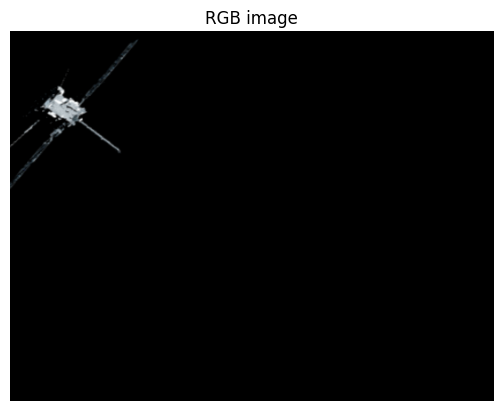

In [4]:
# Plot the transformed image
import matplotlib.pyplot as plt
img_np = transform(img).permute(1, 2, 0).cpu().numpy()

plt.imshow(img_np)
plt.title("RGB image")
plt.axis("off")
plt.show()

In [11]:
from models import UnetAdaptiveBins
import model_io

MIN_DEPTH = 1e-3
MAX_DEPTH_NYU = 10
MAX_DEPTH_KITTI = 80

N_BINS = 256

#INFERENCE


# KITTI
model = UnetAdaptiveBins.build(n_bins=N_BINS, min_val=MIN_DEPTH, max_val=MAX_DEPTH_KITTI)
#pretrained_path = "/content/drive/MyDrive/CS 7643/final_project/kitti/AdaBins_kitti.pt"
#model, _, _ = model_io.load_checkpoint(pretrained_path, model)

dhruv_trained=  "/content/drive/MyDrive/CS 7643/final_project/AdaBins/checkpoints/without_aug.pt"
model, _, _ = model_io.load_checkpoint(dhruv_trained, model)
model = model.cuda().eval()

bin_edges, predicted_depth = model(example_rgb_batch)

Loading base model ()...

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


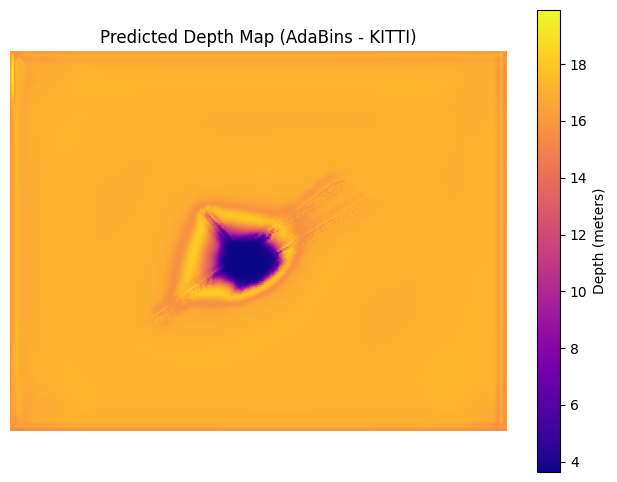

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Remove batch and channel dimensions, move to CPU, convert to numpy
depth_map = predicted_depth.squeeze().detach().cpu().numpy()

# Plot with colormap
plt.figure(figsize=(8, 6))
plt.imshow(depth_map, cmap='plasma')  # You can also try 'viridis', 'magma', etc.
plt.colorbar(label="Depth (meters)")
plt.title("Predicted Depth Map (AdaBins - KITTI)")
plt.axis("off")
plt.show()


In [ ]:
import glob, os, random, pathlib
#prepare text files

ROOT = "/content/drive/MyDrive/CS 7643/final_project/dataset_DL"


# Get image paths
train_files = sorted(glob.glob(f"{ROOT}/train_preprocessed/*.png"))
val_files   = sorted(glob.glob(f"{ROOT}/val_preprocessed/*.png"))

def write_list(rgb_paths, split_name):
    with open(f"{split_name}.txt", "w") as f:
        for rgb_path in rgb_paths:
            filename = pathlib.Path(rgb_path).name
            rgb_rel = f"{pathlib.Path(rgb_path).parent.name}/{filename}"
            depth_rel = f"depth_preprocessed/{filename}"
            f.write(f"{rgb_rel} {depth_rel} 575.0\n")

write_list(train_files, "train_DL")
write_list(val_files, "val_DL")

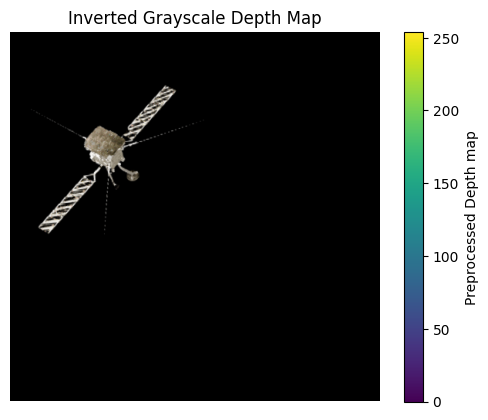

(480, 480, 3)


In [ ]:
#load in one preprocessed depth map, confirm min and max values:
#imread grayscale by default scales values
import cv2
import numpy as np
path =  "/content/drive/MyDrive/CS 7643/final_project/dataset_DL/train_preprocessed/02_img_0000000030.png"
# Load as-is
depth = cv2.imread(path)
# Print stats


#depth = np.clip(depth, 5, None)  # values < 0.1 become 0.1


#inv_depth = 1.0 / depth

#final_depth = inv_depth * 256

# Display
plt.imshow(depth)
plt.colorbar(label="Preprocessed Depth map")
plt.title("Inverted Grayscale Depth Map")
plt.axis("off")
plt.show()
print(np.shape(depth))



#need to normalize these so that the back is a 1,




2.1210938 20.0 19.658134


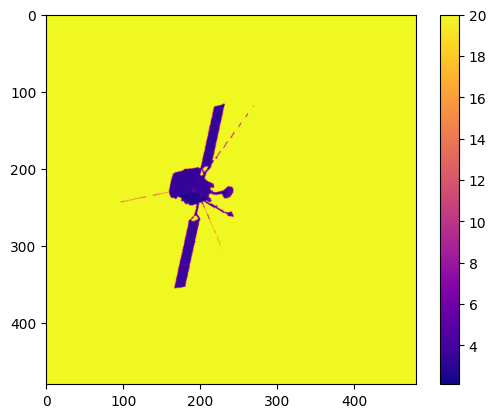

In [ ]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
sample = imageio.imread("/content/drive/MyDrive/CS 7643/final_project/dataset_DL/depth_preprocessed/02_img_0000001505.png").astype('float32') / 256
print(sample.min(), sample.max(), sample.mean())   # should be ~1 … ~80
plt.imshow(sample, cmap='plasma'); plt.colorbar(); plt.show()


In [ ]:
#training configs
#need to add path to txt files

%%bash
cat > args_train_DL.txt <<'EOF'
--bs 8
--dataset kitti
--epochs 20
--n_bins 256
--norm linear
--lr 3.5e-4
--w_chamfer 0.1

--data_path   /content/drive/MyDrive/CS 7643/final_project/dataset_DL
--gt_path     /content/drive/MyDrive/CS 7643/final_project/dataset_DL
--filenames_file       /content/drive/MyDrive/CS 7643/final_project/AdaBins/train_DL.txt
--filenames_file_eval  /content/drive/MyDrive/CS 7643/final_project/AdaBins/val_DL.txt

--input_height 416
--input_width  544
--min_depth 1e-3
--max_depth 80
--validate_every 500
EOF


In [ ]:
import os
import sys
import torch
import subprocess

#insall pytroch3d
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=4c5d0c7ccf66737bcc9d45a4a76597d909d9cc72f770932a91dff3c05930b777
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built iopath
Trying to install wheel for PyTorch3D
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py311_cu124_pyt260/download.html
ERROR: Could not find a version that satisfies the requirement pytorch3d (from versions: none)
ERROR: No matching distribution found for pytorch3d
failed to find/install wheel for py311_cu124_pyt260
Installing PyTorch3D from source
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-ikngxwal
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git

In [ ]:
%%bash
pip uninstall -y numpy
pip install --quiet "numpy<2.0"


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.1 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:

import wandb
wandb.login(key="e56057e60e79ad91b93420403f3567a92a20926b")






wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dhruvahuja9000 (dhruvahuja9000-georgia-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
%%bash
python train.py \
--bs 8 \
--dataset kitti \
--epochs 3 \
--n_bins 256 \
--norm linear \
--lr 3.5e-4 \
--w_chamfer 0.1 \
--data_path /content/drive/MyDrive/CS\ 7643/final_project/dataset_DL \
--gt_path /content/drive/MyDrive/CS\ 7643/final_project/dataset_DL/ \
--data_path_eval /content/drive/MyDrive/CS\ 7643/final_project/dataset_DL/ \
--gt_path_eval /content/drive/MyDrive/CS\ 7643/final_project/dataset_DL/ \
--filenames_file /content/drive/MyDrive/CS\ 7643/final_project/AdaBins/train_DL.txt \
--filenames_file_eval /content/drive/MyDrive/CS\ 7643/final_project/AdaBins/val_DL.txt \
--input_height 480 \
--input_width 480 \
--min_depth 1e-3 \
--max_depth 80 \
--validate_every 100


0
tcp://127.0.0.1:15008
Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.
0 0 8 11
Training UnetAdaptiveBins
Using diff LR


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
wandb: Currently logged in as: dhruvahuja9000 (dhruvahuja9000-georgia-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in ./wandb/run-20250425_205115-w7lskykk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run UnetAdaptiveBins_25-Apr_20-51-nodebs8-tep3-lr0.00035-wd0.1-a565f6d3-1a5e-4094-931f-6c9dd499cf95
wandb: ⭐️ View project at https://wandb.ai/dhruvahuja9000-georgia-institute-of-technology/MDE-AdaBins-kitti
wandb: 🚀 View run at https://wandb.ai/dhruvahuja9000-georgia-institute-of-techn

In [ ]:
!find . -name '*UnetAdaptiveBins*best.pt'
